In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string


In [67]:
dtypes = {"issue_d":"str", "earliest_cr_line":"str", "last_pymnt_d":"str", "next_pymnt_d":"str", "last_credit_pull_d":"str"}
df = pd.read_csv("/Users/partwalk/Projects/Upgrad/loan.csv", dtype=dtypes)

In [68]:
# Drop the columns with only NaN values

for x in df.columns:
    if df[x].isnull().all():
        df.drop(x, axis=1, inplace=True)

In [80]:
# Checking which columns have a single value, and what the value is

for x in df.columns:
    if len(df[x].unique()) == 1:
        print(x, df[x][0])
    elif len(df[x].unique()) == 4:
        print(x, df[x].unique())

pub_rec_bankruptcies [ 0.  1.  2. nan]


In [70]:
# Deleting the above columns with a single value

for x in df.columns:
    if len(df[x].unique()) == 1:
        df.drop(x, axis=1, inplace=True)

In [71]:
# Dropping since these 3 columns only have values of 0 or NaN. next_pymnt_d has values either 'Jun-16' or 'Jul-16'
df.drop(['collections_12_mths_ex_med', 'chargeoff_within_12_mths', 'tax_liens', 'next_pymnt_d'], axis=1, inplace=True)

In [14]:
# These are unnecessary, but not dropping them right now

# df.drop(['issue_d', 'url', 'desc', 'title', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d'], axis=1, inplace=True)

In [72]:
# Which columns have a mojority null values

for x in df.columns:
    percent_null = (df[x].isnull().sum() * 100) / df.shape[0]
    if percent_null > 50:
        print(x, percent_null)

mths_since_last_delinq 64.66248709620565
mths_since_last_record 92.98537150338646


In [73]:
# Change int_rate and revol_util, which are percentages, to float

df['int_rate'] = df['int_rate'].str.strip(' %').astype('float') / 100
df['revol_util'] = df['revol_util'].str.strip(' %').astype('float') / 100

In [75]:
# Change 'term' column to int64

if all(df['term'].str.endswith('months')):
    df['term'] = pd.to_numeric(df['term'].str.strip(' months'))

In [76]:
# Chane employee_length to float

df['emp_length'] = df['emp_length'].str.strip(' years')
df['emp_length'] = df['emp_length'].str.strip(' year')
df['emp_length'] = df['emp_length'].str.strip('+')
df['emp_length'] = df['emp_length'].apply(lambda x: 0 if x == '< 1' else x)
df['emp_length'] = pd.to_numeric(df['emp_length'])


In [49]:
df.groupby('home_ownership')['loan_status'].value_counts(normalize=True, dropna=True)

home_ownership  loan_status
MORTGAGE        Fully Paid     0.832097
                Charged Off    0.131774
                Current        0.036129
NONE            Fully Paid     1.000000
OTHER           Fully Paid     0.816327
                Charged Off    0.183673
OWN             Fully Paid     0.827992
                Charged Off    0.144866
                Current        0.027142
RENT            Fully Paid     0.827610
                Charged Off    0.150220
                Current        0.022170
Name: proportion, dtype: float64

Per above, 18.3% of people who listed 'OTHER' under home ownership defaulted their loan.
Comparitively, of the people who rented/mortgaged/owned homes, the default rate was at most 15%.
The 'OTHER' category can be seen as a risk factor for delinquency.


In [128]:
c = df.groupby('purpose')['loan_status'].value_counts(normalize=True, dropna=True)
c.xs('Charged Off', level=1).sort_values(ascending=False)

purpose
small_business        0.259847
renewable_energy      0.184466
educational           0.172308
other                 0.158527
moving                0.157804
house                 0.154856
medical               0.152958
debt_consolidation    0.148436
vacation              0.139108
home_improvement      0.116599
credit_card           0.105653
car                   0.103292
major_purchase        0.101509
wedding               0.101373
Name: proportion, dtype: float64

26% of all loans taken for Small Businesses end in default.
Renewable Energy, Educational, Other, Moving, House, and Medical loans all have a default rate above 15%.

In [126]:
df.groupby('verification_status')['loan_status'].value_counts(normalize=True, dropna=True)


verification_status  loan_status
Not Verified         Fully Paid     0.859996
                     Charged Off    0.126588
                     Current        0.013415
Source Verified      Fully Paid     0.825373
                     Charged Off    0.143587
                     Current        0.031040
Verified             Fully Paid     0.792802
                     Charged Off    0.160122
                     Current        0.047076
Name: proportion, dtype: float64

Both Verified and Source Verified have a higher default rate than Not Verified status. This could be because the lender places too much of an emphasis on verification,
leading them to take a greater risk on borrowers with verified incomes. This risk is not justified. 
One way of reducing defaults would be to decrease the importance of verification in their decision matrix.

In [77]:
df.groupby('grade')['loan_status'].value_counts(normalize=True, dropna=True)

grade  loan_status
A      Fully Paid     0.936341
       Charged Off    0.059693
       Current        0.003966
B      Fully Paid     0.852745
       Charged Off    0.118552
       Current        0.028702
C      Fully Paid     0.801062
       Charged Off    0.166337
       Current        0.032601
D      Fully Paid     0.747503
       Charged Off    0.210665
       Current        0.041832
E      Fully Paid     0.685433
       Charged Off    0.251583
       Current        0.062984
F      Fully Paid     0.626311
       Charged Off    0.304099
       Current        0.069590
G      Fully Paid     0.626582
       Charged Off    0.319620
       Current        0.053797
Name: proportion, dtype: float64

In [60]:
# Convert loan_status to a binary: 1 for default, 0 for no
defaulted = df['loan_status'].apply(lambda x: 1 if x == 'Charged Off' else 0)
# Convert grades to its numeric value
grade_num = df['grade'].apply(lambda x: string.ascii_uppercase.index(x))
grade_num.corr(defaulted)

np.float64(0.1904093598280218)

As the grade decreases in quality, the rate of default shoots up from 5% of Grade A loans to 32% of Grade G loans.
The correlation coefficient of grade vs loan_status is 0.19, which is higher than term and revol_util.
Grade is an extremely strong predictor of delinquency.

In [58]:
# Finding the correlation between loan_status and DTI

defaulted = df['loan_status'].apply(lambda x: 1 if x == 'Charged Off' else 0)

In [81]:
#  Finding the correlation between loan_status and DTI
arr = []
for i in df.columns:
    try:
        arr.append((df[i].corr(defaulted), i))
    except:
        continue
sorted(arr)

[(np.float64(-0.3350189558357645), 'total_rec_prncp'),
 (np.float64(-0.23884351067418763), 'total_pymnt'),
 (np.float64(-0.23623247297689037), 'total_pymnt_inv'),
 (np.float64(-0.2149492862554395), 'last_pymnt_amnt'),
 (np.float64(-0.0554760435362905), 'out_prncp'),
 (np.float64(-0.055417349464572344), 'out_prncp_inv'),
 (np.float64(-0.04166180205780614), 'annual_inc'),
 (np.float64(-0.02356265946099974), 'total_acc'),
 (np.float64(-0.010780379617828137), 'total_rec_int'),
 (np.float64(-0.010741653768281402), 'open_acc'),
 (np.float64(0.0033688357297216513), 'revol_bal'),
 (np.float64(0.004941107969798992), 'mths_since_last_delinq'),
 (np.float64(0.012159760102357265), 'emp_length'),
 (np.float64(0.019904373876979374), 'delinq_2yrs'),
 (np.float64(0.02258872906287438), 'installment'),
 (np.float64(0.026438306745475336), 'member_id'),
 (np.float64(0.026620704677503527), 'funded_amnt_inv'),
 (np.float64(0.02836956551416956), 'id'),
 (np.float64(0.041701263672025236), 'dti'),
 (np.float64

Ignoring the confounders and non-predictive variables such as total_pymnt and recoveries,  annual income is slightly negatively correlated, implying that higher income is associated with lesser delinquency.
On the other hand, term is positively correlated, implying that borrowers who opt for longer terms are more likely to default.
The utilization rate revol_util is also positively correlated, implying that those who use more credit, and thus are more dependent on it, are more likely to default.

In [84]:
defaulters = df[df['loan_status'] == 'Charged Off']
fully_paid = df[df['loan_status'] == 'Fully Paid']
current = df[df['loan_status'] == 'Current']

In [122]:
cname = 'addr_state'
freq = defaulters[cname].value_counts()

defstate = freq.reset_index()
defstate.columns = [cname, 'frequency']
defstate['rank'] = defstate['frequency'].rank(method='first', ascending=False)

freq = fully_paid[cname].value_counts()

paidstate = freq.reset_index()
paidstate.columns = [cname, 'frequency']
paidstate['rank'] = paidstate['frequency'].rank(method='first', ascending=False)

defstate.merge(paidstate, on=cname, how='outer').sort_values('rank_x').head(10)

,addr_state,frequency_x,rank_x,frequency_y,rank_y
4,CA,1125.0,1.0,5824,1.0
9,FL,504.0,2.0,2277,4.0
33,NY,495.0,3.0,3203,2.0
42,TX,316.0,4.0,2343,3.0
30,NJ,278.0,5.0,1512,5.0
10,GA,215.0,6.0,1144,9.0
14,IL,197.0,7.0,1281,7.0
37,PA,180.0,8.0,1288,6.0
44,VA,177.0,9.0,1192,8.0
20,MD,162.0,10.0,861,12.0


California is rank 1 among defaulters' state, but it's also the highest among the non-defaulters. This is probably because it has the highest population.
The top 5 states are all in the top 10 most populated states in the US. No great delta between the two ranks, either.

We could look at lower ranked states, but that has the problem of fewer sample size. We don't want to draw strong conclusions based on small sample size when it comes to states,
since writing off entire states could lead to major loss of business.


In [123]:
cname = 'zip_code'
freq = defaulters[cname].value_counts()

defrank = freq.reset_index()
defrank.columns = [cname, 'frequency']
defrank['rank'] = defrank['frequency'].rank(method='first', ascending=False)

freq = fully_paid[cname].value_counts()

paidrank = freq.reset_index()
paidrank.columns = [cname, 'frequency']
paidrank['rank'] = paidrank['frequency'].rank(method='first', ascending=False)

defrank.merge(paidrank, on='zip_code', how='outer').sort_values('rank_x').head(10)

,zip_code,frequency_x,rank_x,frequency_y,rank_y
773,945xx,80.0,1.0,451.0,2.0
748,917xx,71.0,2.0,269.0,14.0
74,100xx,70.0,3.0,513.0,1.0
298,331xx,70.0,4.0,267.0,15.0
757,926xx,67.0,5.0,299.0,11.0
86,112xx,65.0,6.0,437.0,4.0
50,070xx,65.0,7.0,390.0,5.0
727,891xx,64.0,8.0,178.0,33.0
733,900xx,64.0,9.0,382.0,6.0
268,300xx,52.0,10.0,331.0,8.0


Zipcodes has the same problem as states; the highest ranks would all bias toward those areas with greater population.
But we can look at the delta between the two ranks.
Zipcodes beginning with 917, 331, 926 and especially 891 contain a higher proportion of defaulters, compared to other zipcodes like 945 and 100.
These zipcodes have a far greater frequency amongst deliquents, as shown by the difference in rank_x and rank_y.

We don't look at ranks below 10 for similar reasons as given for states.

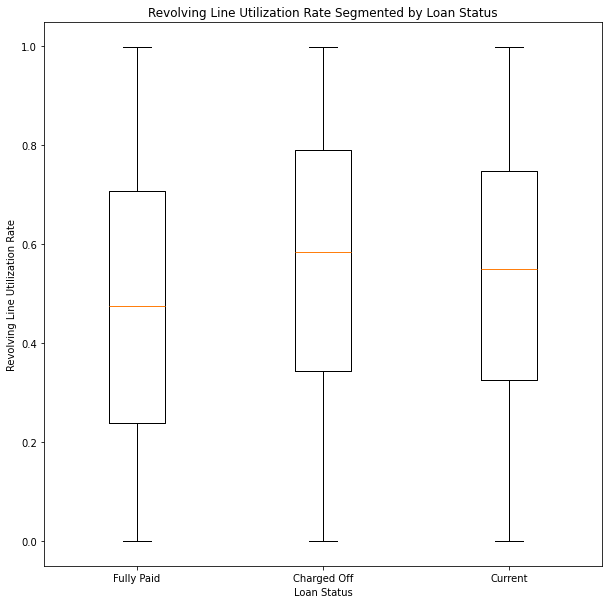

In [87]:
def boxplt(cname, ylabel):
    data = [fully_paid[fully_paid[cname].notna()][cname], defaulters[defaulters[cname].notna()][cname], current[current[cname].notna()][cname]]
    plt.figure(figsize=(10, 10))
    plt.boxplot(data, tick_labels=['Fully Paid', 'Charged Off', 'Current'])
    plt.title(ylabel + ' Segmented by Loan Status')
    plt.xlabel('Loan Status')
    plt.ylabel(ylabel)
    # plt.yscale('log')
    plt.show()

boxplt('revol_util', 'Revolving Line Utilization Rate')

There doesn't seem to be a lot of difference between the annual incomes of people who paid off their loans and those who defaulted. Both cohorts have similar levels of low income. The median is slightly higher for the fully paid cohort, but not enought to be significant. Both have similar first and third quartiles. There's a lot more diversity in the range of incomes among both groups. In contrast, the group paying off open loans on time has a smaller range of incomes. The 'Fully Paid' group has, at the higher end, far greater income than the other two groups, which is as expected. High-income people would be most capable of paying off loans.

The DTI boxplot segmented by Loan Status is similar. The quartiles for defaulters is higher than for "Fully Paid", but lower than "Current". It's hard to draw a strong conclusion from this.

Employee Length, Months Since Last Default, and Total Number of Credit Lines have similarly weak evidence.

The Revolving Line Utilization Rate (RLUR) is significantly higher for deliquient borrowers than for other groups. While the minima and maxima are similar for all groups, all three quartiles are higher for deliquients compared to the other two groups.
